In [1]:
# Importing Libraries
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

from tensorflow.keras.models import Model

In [2]:
# Load Data
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
# Map data to -1 to +1
X_train, X_test = X_train /255.0 * 2 - 1, X_test /255.0 * 2 - 1

In [4]:
# Reshape train and test data
X_train = X_train.reshape(-1, X_train.shape[1] * X_train.shape[2])
X_test = X_test.reshape(-1, X_test.shape[1] * X_test.shape[2])

In [5]:
# Set discriminator and generator input shape
d_input = X_train.shape[1]
g_input = 10

In [6]:
def create_discriminator(input_shape):

    model = tf.keras.models.Sequential()
    model.add(tf.keras.Input(shape=input_shape))
    model.add(tf.keras.layers.Dense(512, activation=tf.keras.layers.LeakyReLU(alpha=0.3)))
    model.add(tf.keras.layers.Dense(256, activation=tf.keras.layers.LeakyReLU(alpha=0.3)))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    opt = tf.keras.optimizers.Adam(0.0002, 0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [7]:
def create_generator(input_shape):
    # Creating Generator
    model = tf.keras.models.Sequential()
    model.add(tf.keras.Input(shape=(input_shape,)))
    model.add(tf.keras.layers.Dense(256, activation=tf.keras.layers.LeakyReLU(alpha=0.3)))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.99))
    model.add(tf.keras.layers.Dense(512, activation=tf.keras.layers.LeakyReLU(alpha=0.3)))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.99))
    model.add(tf.keras.layers.Dense(1024, activation=tf.keras.layers.LeakyReLU(alpha=0.3)))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.99))
    model.add(tf.keras.layers.Dense(28*28, activation='tanh'))

    opt = tf.keras.optimizers.Adam(0.0002, 0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               2816      
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              525312    
_________________________________________________________________
batch_normalization_2 (Batch (None, 1024)              4096      
_________________________________________________________________
dense_3 (Dense)              (None, 784)               8

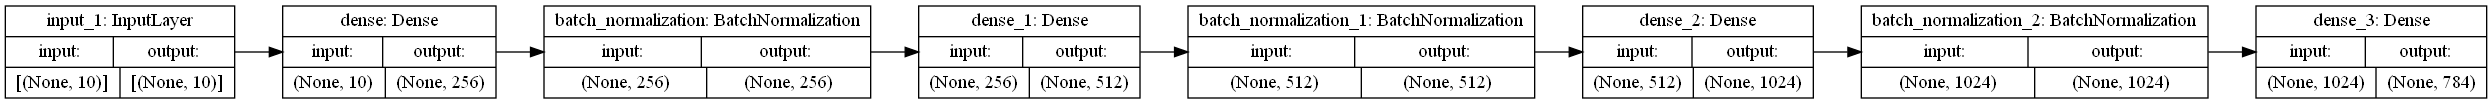

In [8]:
generator = create_generator(g_input)
generator.summary()
tf.keras.utils.plot_model(
    generator,
    to_file="generator.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="LR",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    # show_layer_activations=False,
)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________


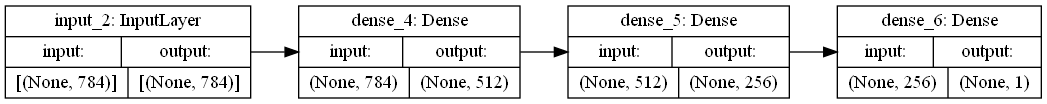

In [9]:
discriminator = create_discriminator(d_input)
discriminator.summary()
tf.keras.utils.plot_model(
    discriminator,
    to_file="discriminator.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="LR",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    # show_layer_activations=False,
)

In [10]:
def predict_and_save_plot(generator, e):
    # Predicting the results after training
    gen_image = generator.predict(np.random.randn(10*10, g_input))
    gen_image = 0.5 * gen_image + 0.5   # Rescale it to 0 to 1 range
    plt.figure(1)
    for i in range(1,10*10+1):
        plt.subplot(10,10,i)
        plt.imshow(gen_image[i-1].reshape((28,28)), cmap="gray")
        plt.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)    
    plt.savefig(f"{str(e)}.jpg")

In [11]:
def save_acc_loss_plot(acc_list, loss_list, ep):
    # Accuracy and Loss plot per epoch training
    plt.figure(2)
    plt.plot(ep, acc_list, label="Accuracy")
    plt.plot(ep, loss_list, label="Loss")
    plt.legend(loc='best')
    plt.savefig(f"Accuracy_and_Loss.jpg")
    plt.show()

In [12]:
def save_model_weights(discriminator, generator, gan):
    # Saving the Weights
    discriminator.trainable = False
    gan.save(f"./Models/gan.h5")
    discriminator.trainable = True
    generator.save(f"./Models/generator.h5")
    discriminator.save(f"./Models/discriminator.h5")

In [13]:
def save_as_json(discriminator, generator, gan):
    # Saving as JSON
    discriminator.trainable = False
    gan_json = gan.to_json()
    with open(f"./Models/gan.json", 'w') as json_file:
        json_file.write(gan_json)
    discriminator.trainable = True
    generator_json = generator.to_json()
    with open(f"./Models/generator.json", 'w') as json_file:
        json_file.write(generator_json)    
    discriminator_json = discriminator.to_json()
    with open(f"./Models/discriminator.json", 'w') as json_file:
        json_file.write(discriminator_json)

In [14]:
def create_GAN(discriminator, generator):
    # Generative Adversarial Network
    input_layer = tf.keras.layers.Input(shape=(g_input))
    gen_out = generator(input_layer)
    disc_out = discriminator(gen_out)

    gan = Model(input_layer,disc_out)

    discriminator.trainable = False
    opt = tf.keras.optimizers.Adam(0.0002, 0.5)
    gan.compile(loss='binary_crossentropy', optimizer=opt)#, metrics=['accuracy'])
    gan.summary()
    return gan

In [15]:
def training_GAN(discriminator, generator, gan, x, batch):
    idx = np.random.randint(0, x.shape[0], batch)
    gen_examples = generator.predict(np.random.randn(batch, g_input))
    
    discriminator.train_on_batch(x[idx], np.ones(batch))
    discriminator.train_on_batch(gen_examples, np.zeros(batch))

    g_loss = gan.train_on_batch(np.random.randn(batch, g_input), np.ones(batch))
    _, acc_real = discriminator.evaluate(x[idx], np.ones(batch), verbose=False)
    _, acc_fake = discriminator.evaluate(gen_examples, np.zeros(batch), verbose=False)
    d_acc = (acc_real + acc_fake)/2
    
    return d_acc, g_loss

In [16]:
# Create GAN
gan = create_GAN(discriminator, generator)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
sequential (Sequential)      (None, 784)               1470480   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 533505    
Total params: 2,003,985
Trainable params: 1,466,896
Non-trainable params: 537,089
_________________________________________________________________


Epoch no: 100
Generator Loss: 3.938267230987549
Discriminator Accuracy: 0.984375
Epoch no: 200
Generator Loss: 3.8807177543640137
Discriminator Accuracy: 0.8046875
Epoch no: 300
Generator Loss: 3.139019727706909
Discriminator Accuracy: 1.0
Epoch no: 400
Generator Loss: 2.7833006381988525
Discriminator Accuracy: 0.9453125
Epoch no: 500
Generator Loss: 0.9251407980918884
Discriminator Accuracy: 0.90625
Epoch no: 600
Generator Loss: 0.8462663292884827
Discriminator Accuracy: 0.9375
Epoch no: 700
Generator Loss: 0.8651834726333618
Discriminator Accuracy: 0.96875
Epoch no: 800
Generator Loss: 0.8199331760406494
Discriminator Accuracy: 0.90625
Epoch no: 900
Generator Loss: 0.8632413148880005
Discriminator Accuracy: 0.953125
Epoch no: 1000
Generator Loss: 0.9482103586196899
Discriminator Accuracy: 0.9609375
Epoch no: 1100
Generator Loss: 0.917615532875061
Discriminator Accuracy: 0.9140625
Epoch no: 1200
Generator Loss: 1.0074794292449951
Discriminator Accuracy: 0.9375
Epoch no: 1300
Generator

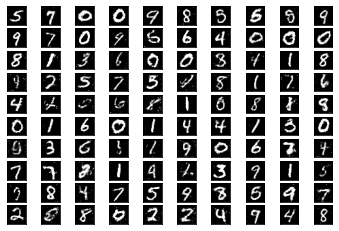

In [17]:
epochs = 40000
batch_size = 64
gan_loss = []
dis_acc = []
for e in range(1, epochs+1):
    acc, loss = training_GAN(discriminator, generator, gan, X_train, batch_size)
    gan_loss.append(loss)
    dis_acc.append(acc)
    if e % 100 == 0:
        print(f"Epoch no: {e}")
        print(f"Generator Loss: {loss}")
        print(f"Discriminator Accuracy: {acc}")
    
    if e % 2500 == 0:
        predict_and_save_plot(generator, e)

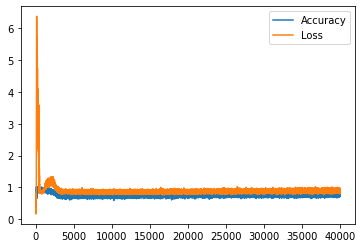

In [18]:
save_acc_loss_plot(dis_acc, gan_loss, range(1,epochs+1))

In [19]:
save_model_weights(discriminator, generator, gan)

In [20]:
save_as_json(discriminator, generator, gan)